<a href="https://colab.research.google.com/github/JJJavier23/CSUSM_SoftwareEngineering/blob/main/LSTM_class_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make sure you are using a GPU

Let's define the default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
#from packaging import version

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preparing the Data for Machine Learning Models


Build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. You have access to daily ridership data since 2001. Download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

# Download the dataset from here: https://drive.google.com/file/d/12xwLD3YHvMAhATkRSCXKV63R6WecAiqi/view?usp=sharing

In [3]:
import pandas as pd
path = "/content/drive/My Drive/ridership.csv"
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

We load the CSV file, set short column names, sort the rows by date, remove the redundant total column, and drop duplicate rows. Now let’s check what the first few rows look like:

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917



On January 1st, 2001, 297,192 people boarded a bus in Chicago, and 126,455 boarded a train. The day_type column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.
Now let’s plot the bus and rail ridership figures over a few months in 2019, to see what it looks like:

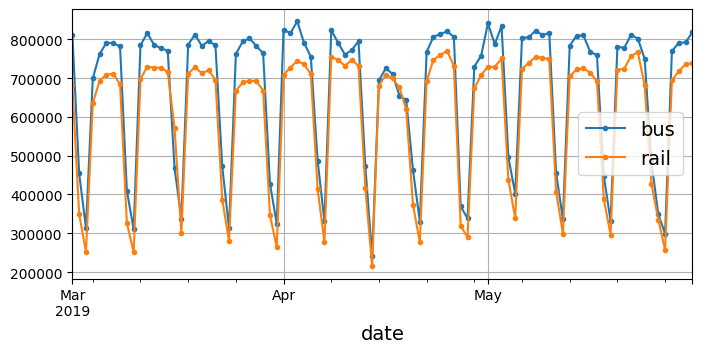

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Let’s try to use a basic linear model for prediction. **Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days)**. The inputs to our model will therefore be sequences, each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

But what will we use as training data?
We will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

Keras actually has a nice utility function called tf.keras.utils.timeseries_ dataset_from_array() to help us prepare the training set. It takes a time series as input, and it builds a tf.data.Dataset containing all the windows of the desired length, as well as their corresponding targets.

Here is an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [6]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Each sample in the dataset is a window of length 3, along with its corresponding target (i.e., the value immediately after the window). The windows are [0, 1, 2], [1, 2, 3], and [2, 3, 4], and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [7]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Next, let’s use timeseries_dataset_from_array() to create datasets for training and validation. We must set the argument shuffle=True to shuffle the training windows (but not their contents)

In [8]:
seq_length = 56
tf.random.set_seed(42)  # ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

And now we’re ready to build and train any regression model we want!

# Forecasting Using a Linear Model

Let’s try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the MAE directly.

In [9]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0205 - mae: 0.1672 - val_loss: 0.0072 - val_mae: 0.0936
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0999 - val_loss: 0.0055 - val_mae: 0.0796
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0888 - val_loss: 0.0052 - val_mae: 0.0764
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0821 - val_loss: 0.0049 - val_mae: 0.0729
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0804 - val_loss: 0.0046 - val_mae: 0.0705
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0730 - val_loss: 0.0046 - val_mae: 0.0691
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0765 - val_loss: 0.0045 - val_mae: 0.0673
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0720 - val_loss: 0.0045 - val_mae: 0.0670
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

In [10]:
# evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
print("Linear Model MAE:", valid_mae * 1e6)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020 - mae: 0.0408
Linear Model MAE: 39958.26467871666


This model reaches a validation MAE of about 39900 (your mileage may vary).

Task:

Implement a deep RNN by stacking recurrent layers.
Use three SimpleRNN layers with 32 neurons. The first two are sequence-to-sequence layers, and the last one is a sequence-to-vector layer. Finally, the Dense layer produces the model’s forecast.

Try various hyperparameters and compare the valid_mae obtained

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output).

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0655 - mae: 0.2936 - val_loss: 0.0172 - val_mae: 0.1344
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0168 - mae: 0.1593 - val_loss: 0.0161 - val_mae: 0.1638
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0166 - mae: 0.1647 - val_loss: 0.0160 - val_mae: 0.1511
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0160 - mae: 0.1585 - val_loss: 0.0161 - val_mae: 0.1625
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0165 - mae: 0.1628 - val_loss: 0.0163 - val_mae: 0.1427
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0168 - mae: 0.1614 - val_loss: 0.0160 - val_mae: 0.1608
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0169 - mae: 0.1652 - val_loss: 0.0164 - val_mae: 0.1414
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0169 - mae: 0.1607 - val_loss: 0.0178 - val_mae: 0.1300
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.019

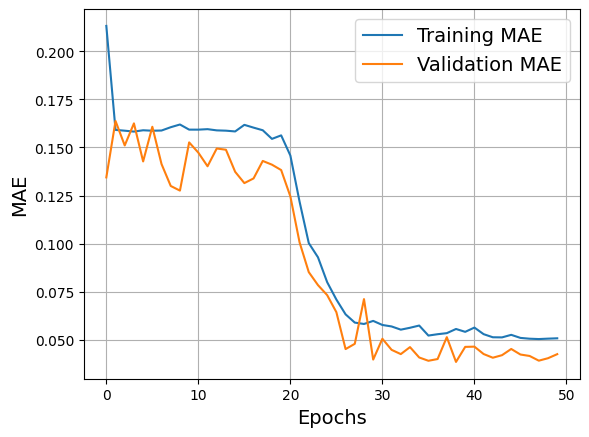

In [12]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[56, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=50)

valid_loss, valid_mae = model.evaluate(valid_ds)
print("LSTM Model MAE:", valid_mae * 1e6)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()